In [ ]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 593kB 7.0MB/s 
     |████████████████████████████████| 112kB 15.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 215kB 12.8MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 849kB 23.9MB/s 
     |████████████████████████████████| 122kB 35.0MB/s 
     |████████████████████████████████| 1.1MB 28.6MB/s 
     |████████████████████████████████| 645kB 50.4MB/s 
     |████████████████████████████████| 686kB 49.9MB/s 
     |████████████████████████████████| 1.2MB 46.8MB/s 
     |████████████████████████████████| 6.3MB 41.6MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 37.2MB 1.3MB/s 
     |████████████████████████████████| 358kB 47.2MB/s 
     |████████████████████████████████| 204kB 57.4MB/s 


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install pytorchcv-0.0.55-py2.py3-none-any.whl

In [ ]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
TEST_DIR = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/test_videos'

In [ ]:
test_videos = sorted([x for x in os.listdir(TEST_DIR) if x[-4:] == ".mp4"])

In [ ]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"jeejeeyoung","key":"9ac1aa0685cbd6493cfb8ae6fc1a67bb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d humananalog/deepfakes-inference-demo

deepfakes-inference-demo.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle datasets download -d humananalog/blazeface-pytorch

blazeface-pytorch.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir deepfakes-inference-demo
!mkdir blazeface-pytorch
!unzip /content/deepfakes-inference-demo.zip -d deepfakes-inference-demo
!unzip /content/blazeface-pytorch.zip -d blazeface-pytorch

mkdir: cannot create directory ‘deepfakes-inference-demo’: File exists
mkdir: cannot create directory ‘blazeface-pytorch’: File exists
Archive:  /content/deepfakes-inference-demo.zip
replace deepfakes-inference-demo/helpers/face_extract_1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: deepfakes-inference-demo/helpers/face_extract_1.py  
replace deepfakes-inference-demo/helpers/read_video_1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: deepfakes-inference-demo/helpers/read_video_1.py  
replace deepfakes-inference-demo/resnext.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: deepfakes-inference-demo/resnext.pth  
Archive:  /content/blazeface-pytorch.zip
replace blazeface-pytorch/anchors.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: blazeface-pytorch/anchors.npy  
replace blazeface-pytorch/blazeface.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: blazeface-pytorch/blazeface.pth  
replace blazeface-pytorch/blazeface.py? [y]es, [n]o, [A]ll

In [ ]:
import sys
sys.path.insert(0, "/content/blazeface-pytorch")
sys.path.insert(0, "/content/deepfakes-inference-demo")

In [ ]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/content/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/content/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [ ]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 20

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [ ]:
input_size = 150

In [ ]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [ ]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [ ]:
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=False)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))

class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()

    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.5)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)

  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

In [ ]:
net = []
model = FCN(model, 2048)
model = model.cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/model.pth'))
net.append(model)

In [ ]:
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)

        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))

                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)
#                     x[i] = x[i] / 255.

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(TEST_DIR, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [ ]:
speed_test = False

In [ ]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

In [ ]:
%%time
model.eval()
predictions = predict_on_video_set(test_videos, num_workers=4)

CPU times: user 34min 49s, sys: 27.2 s, total: 35min 17s
Wall time: 18min 13s


In [ ]:
submission_df = pd.DataFrame({"filename": test_videos, "label": predictions})

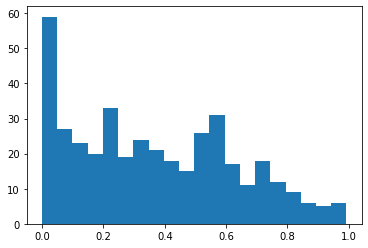

In [ ]:
submission_df.sort_values('filename')
plt.hist(submission_df.label, 20)
plt.show()

In [ ]:
submission_df.head(10)

,filename,label
0,aassnaulhq.mp4,0.722933
1,aayfryxljh.mp4,0.034791
2,acazlolrpz.mp4,0.565257
3,adohdulfwb.mp4,0.013696
4,ahjnxtiamx.mp4,0.301616
5,ajiyrjfyzp.mp4,0.366389
6,aktnlyqpah.mp4,0.071791
7,alrtntfxtd.mp4,0.543248
8,aomqqjipcp.mp4,0.541107
9,apedduehoy.mp4,0.022958
